# HW2

## GENERAL INSTRUCTIONS:

- CLEARLY mark where you are answering each question (all questions must be answered in Markdown cells, NOT as comments in code cells)
- Show all code necessary for the analysis, but remove superfluous code
- Check that your final PDF does not have code/markdown cutoff

---

Use the [Loan Dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv) on GitHub to build the classification models described below.

## Variable Descriptions:
- `age`: age in years of person.
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have.
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`.
- `income_in_k`: income in thousands of dollars.
- `state`: state person lives in.
- `credit_score`: credit score.
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
- `gave_loan`: whether or not the person got a loan.

## Instructions
1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan using all the other variables.*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training! see [here](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Extras/get_dummies.ipynb)).
    - use the `train_test_split()` to do an 80/20 split (make sure to use the SAME split when training all 3 models, do not re-split your data. We want each model to be trained on the same training set).
    - Appropriately z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using `GridSearchCV`.
    - For Decision Trees, use `GridSearchCV` to choose max_depth, and make sure to check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices for both train and test.
    
    
2. *Evaluate Your Models (WRITE YOUR ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy AND confusion matrices, **thoroughly discuss which model did best (if you had to pick one), how can you tell?**
    - B) **Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs?** (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased against/for certain gender groups).
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.**

# 1.

In [28]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

loan = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv")
loan.head()

,age,had_cancer,gender_id,income_in_k,state,credit_score,num_credit_sources,utilization_rate,gave_loan
0,39,0,Female,54,TX,448,4,0.32,0
1,43,0,Female,66,NJ,399,4,0.35,0
2,42,0,Male,50,NE,509,8,0.23,0
3,46,0,Female,79,TX,540,6,0.15,0
4,43,0,Female,49,NV,485,10,0.20,0


## Setting up dummy variables

In [29]:
stateDummies = pd.get_dummies(loan["state"])
genderDummies = pd.get_dummies(loan["gender_id"])

loan = pd.concat([loan, genderDummies, stateDummies], axis = 1)

loan = loan.drop("state", 1)
loan = loan.drop("gender_id", 1)


loan.columns

Index(['age', 'had_cancer', 'income_in_k', 'credit_score',
       'num_credit_sources', 'utilization_rate', 'gave_loan', 'Female', 'Male',
       'Non-Binary', 'Survey Choices Do Not Accurately Reflect My Identity',
       'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY'],
      dtype='object')

## Setting up TTS for all models

In [30]:



# what K do I use??
predictors = ['age', 'had_cancer', 'income_in_k', 'credit_score',
       'num_credit_sources', 'utilization_rate', 'Female', 'Male',
       'Non-Binary', 'Survey Choices Do Not Accurately Reflect My Identity',
       'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY']

contin = ["age", "income_in_k", "credit_score", "num_credit_sources", "utilization_rate"]

X = loan[predictors]
y = loan["gave_loan"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)



## Logistic Regression Model

In [31]:
zscore = StandardScaler()
zscore.fit(X_train)
Xz_train = zscore.transform(X_train)
Xz_test = zscore.transform(X_test)
myLogit = LogisticRegression(penalty = "none")
myLogit.fit(Xz_train,y_train)

LogisticRegression(penalty='none')

In [32]:
predictedVals = myLogit.predict(Xz_test)
accuracy_score(y_test,predictedVals)

0.7175

In [33]:
predictedValsTrain = myLogit.predict(Xz_train)
accuracy_score(y_train, predictedValsTrain)

0.739375

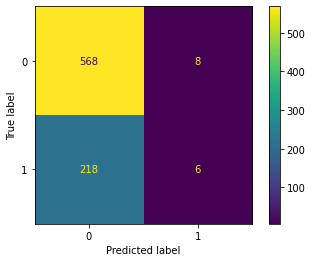

In [34]:
plot_confusion_matrix(myLogit, Xz_test, y_test)

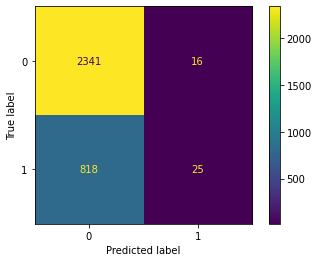

In [35]:
plot_confusion_matrix(myLogit, Xz_train, y_train)

## KNN Model

In [36]:
# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), contin))

# make pipeline
pipe = make_pipeline(z, knn2)
print(pipe.get_params().keys())

# choose potential values of k
ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "accuracy", cv = 5, refit = True)

knnmod = grid.fit(X_train[contin], y_train)

y_pred_test = knnmod.predict(X_test)

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


In [37]:
print(knnmod.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"])

28


In [38]:
knnmod.best_score_

0.7353125

In [39]:
knnmod.score(X_train,y_train)

0.7415625

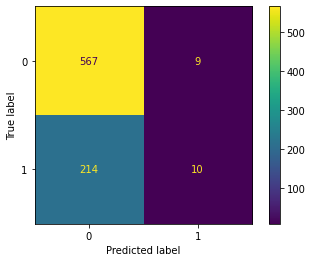

In [40]:
plot_confusion_matrix(knnmod, X_test, y_test)

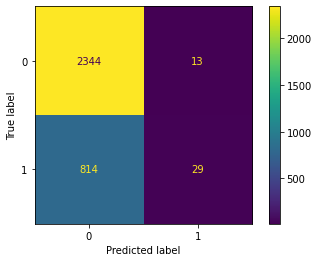

In [41]:
plot_confusion_matrix(knnmod, X_train, y_train)

## Decision Tree Model

In [42]:
tree = DecisionTreeClassifier()

# make pipe
zTree = make_column_transformer((StandardScaler(), contin))

pipeTree = make_pipeline(zTree,tree)
print(pipeTree.get_params().keys())


# choose potential values of k
depths = {"decisiontreeclassifier__max_depth": range(1,9)}

# use grid search to find best parameters
gridTree = GridSearchCV(pipeTree,depths, scoring = "accuracy", cv = 5, refit = True)

DTmod = gridTree.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'decisiontreeclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__standardscaler', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassi

In [43]:
DTmod.best_score_

0.7365625

In [44]:
DTmod.score(X_train,y_train)

0.7365625

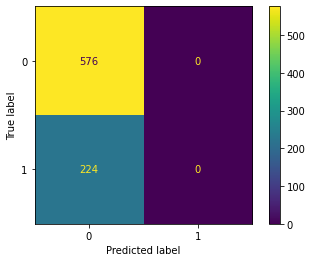

In [45]:
plot_confusion_matrix(DTmod, X_test, y_test)

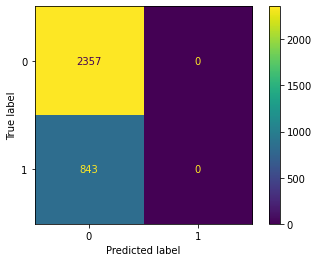

In [46]:
plot_confusion_matrix(DTmod, X_train, y_train)

# Part 2

## A.

None of the models appear to be overfit onto the training data because there is no significant discrepancy between the accuracy score on the training data and that score on the testing data. So we don't have to worry about any models being overfit. All of the models have an accuracy over 70% which means they all perform relatively well. The model that has the highest accuracy score is the decision tree, however from looking at the confusion matrices it is not the best model to use. This is simply because the model never predicts an individual will get a loan from the input data. This means that it will never accurately predict that an individual should receive a loan, meaning no true positives. So that leaves the KNN and logistic regression models to be the best. The KNN model has a higher accuracy score between them two, which means that the KNN model performs better. I can conclude that the KNN model is the best model of these 3 to use on this data.

## B.

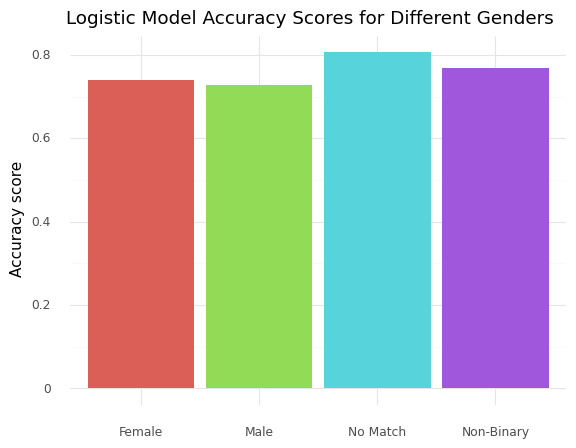

<ggplot: (8760779817961)>

In [58]:
male = (loan.loc[loan["Male"] == 1])
female = (loan.loc[loan["Female"] == 1])
nonbin = (loan.loc[loan["Non-Binary"] == 1])
nomatch = (loan.loc[loan["Survey Choices Do Not Accurately Reflect My Identity"] == 1])

maleX = male[predictors]
maleX = zscore.transform(maleX)
maleacc = accuracy_score(male["gave_loan"], myLogit.predict(maleX))
#print(myLogit.predict(maleX))

femaleX = female[predictors]
femaleX = zscore.transform(femaleX)
femaleacc = accuracy_score(female["gave_loan"], myLogit.predict(femaleX))

nonbinX = nonbin[predictors]
nonbinX = zscore.transform(nonbinX)
nonbinacc = accuracy_score(nonbin["gave_loan"], myLogit.predict(nonbinX))

nomatchX = nomatch[predictors]
nomatchX = zscore.transform(nomatchX)
nomatchacc = accuracy_score(nomatch["gave_loan"], myLogit.predict(nomatchX))

toDFgenders = [["Male", maleacc], ["Female", femaleacc], ["Non-Binary", nonbinacc], ["No Match", nomatchacc]]
genders = pd.DataFrame(toDFgenders, columns = ["Gender", "Accuracy score"])


(ggplot(genders, aes(x = "Gender", y = "Accuracy score", fill = "Gender", label = "Accuracy score")) + geom_bar(stat = "identity")  + theme_minimal() + xlab("") + theme(legend_position = "none") + ggtitle("Logistic Model Accuracy Scores for Different Genders"))

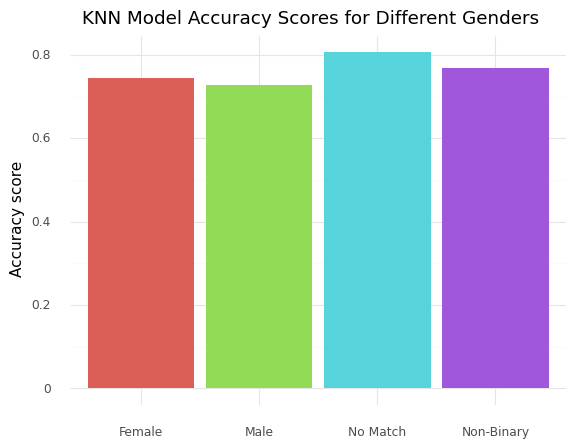

<ggplot: (8760779861273)>

In [48]:
maleX = male[predictors]
maleacc = accuracy_score(male["gave_loan"], knnmod.predict(maleX))

femaleX = female[predictors]
femaleacc = accuracy_score(female["gave_loan"], knnmod.predict(femaleX))

nonbinX = nonbin[predictors]
nonbinacc = accuracy_score(nonbin["gave_loan"], knnmod.predict(nonbinX))

nomatchX = nomatch[predictors]
nomatchacc = accuracy_score(nomatch["gave_loan"], knnmod.predict(nomatchX))

toDFgenders = [["Male", maleacc], ["Female", femaleacc], ["Non-Binary", nonbinacc], ["No Match", nomatchacc]]
genders = pd.DataFrame(toDFgenders, columns = ["Gender", "Accuracy score"])


(ggplot(genders, aes(x = "Gender", y = "Accuracy score", fill = "Gender", label = "Accuracy score")) + geom_bar(stat = "identity")  + theme_minimal() + xlab("") + theme(legend_position = "none") + ggtitle("KNN Model Accuracy Scores for Different Genders"))

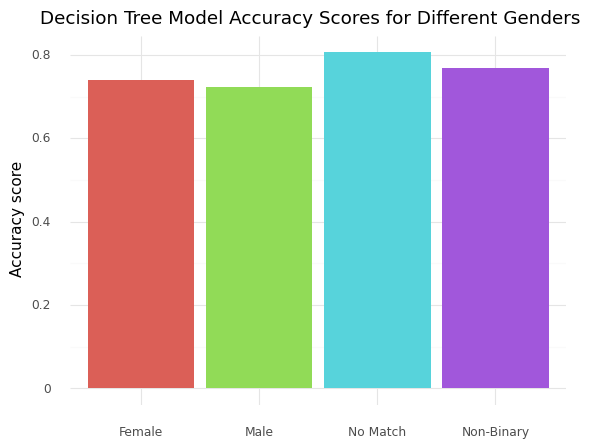

<ggplot: (8760779758077)>

In [49]:
maleX = male[predictors]
maleacc = accuracy_score(male["gave_loan"], DTmod.predict(maleX))

femaleX = female[predictors]
femaleacc = accuracy_score(female["gave_loan"], DTmod.predict(femaleX))

nonbinX = nonbin[predictors]
nonbinacc = accuracy_score(nonbin["gave_loan"], DTmod.predict(nonbinX))

nomatchX = nomatch[predictors]
nomatchacc = accuracy_score(nomatch["gave_loan"], DTmod.predict(nomatchX))

toDFgenders = [["Male", maleacc], ["Female", femaleacc], ["Non-Binary", nonbinacc], ["No Match", nomatchacc]]
genders = pd.DataFrame(toDFgenders, columns = ["Gender", "Accuracy score"])


(ggplot(genders, aes(x = "Gender", y = "Accuracy score", fill = "Gender", label = "Accuracy score")) + geom_bar(stat = "identity")  + theme_minimal() + xlab("") + theme(legend_position = "none") + ggtitle("Decision Tree Model Accuracy Scores for Different Genders"))

There seems to be a rather slight difference in each model's accuracy for different genders. It is evident that all models best predict the outcome for those with a gender that the survey doesn't match. This is seen through every model having a higher accuracy score for the data of individuals with no match specified for gender. It is also apparent that each model predicts the outcome for males with the least accuracy. This all means that the model is biased in accurately predicting whether a person with a gender that doesn't match the options on the survey will get a loan or not.

## C.

The decision tree model is definitely better at predicting who doesn't get loans because it never makes a positive prediction. This means that it will never make a true positive prediction. The implications of this are that people that deserve loans will never get the loan that they want. This leads to the bank lending the loans out not generating as much money because they never get to lend the loans out. This model could also lead to the economy stagnating if it were implemented widespread with many banks using this model. 

The other two models, KNN and Logistic, both predict individuals not receiving a loan better than when an individual does receive a node. This can be seen through the confusion matrices. For example, with the logistic model there are a total of 14 instances of predicting a positive, getting a loan. It predicted 6 true positives, correctly predicted getting a loan 6 times. This means that when it predicted a positive, it was correct 6/14 times, 42.9% of the time. This model predicted a negative, not getting a loan, 786 times. It predicted 568 true negatives, correctly predicting not getting a loan 568 times. This means that when it predicted a negative, it was correct 568/786 times, 72.3% of the time. This all means that the model is better at predicting not getting a loan.

It is a similar story with the KNN model there are a total of 19 instances of predicting a positive. It predicted 10 true positives. This means that when it predicted a positive, it was correct 10/19 times, 52.6% of the time. This model predicted a negative 781 times. It predicted 567 true negatives. This means that when it predicted a negative, it was correct 567/781 times, 72.6% of the time. This all means that the model is better at predicting not getting a loan.

The implications for these models is similar with the decision tree's implications. It leads to less people getting loans when they should, which causes the bank to lose out on profits as well as the people applying for loans not receiving the money that they need.